# CHM Fractal Analysis: Differential Box Counting & Hypothesis Testing

This notebook performs fractal dimension analysis on Canopy Height Models (CHM) using:

1. **Differential Box Counting (DBC)** - For self-affine fractal dimension of height surfaces
2. **Standard Box Counting** - For self-similar fractal dimension comparison
3. **Lacunarity Analysis** - Scale invariance and gap texture
4. **Zeta Function Analysis** - Gap size distribution for hypothesis testing

## Key Features

- **Interactive AOI Selection** via Leaflet map
- **Proper NoData Handling** - Distinguishes NoData pixels from zero-height (lacunarity=0) pixels
- **Research Hypotheses Testing** - Implements methods from Part V

## Requirements

Create and activate the 3dep conda environment:

```bash
# Create the environment (first time only)
mamba env create -f environments/3dep-environment.yml

# Install the Jupyter kernel
/opt/conda/envs/3dep/bin/python -m ipykernel install --user --name 3dep --display-name "Python (3DEP)"

# Activate the environment
conda activate 3dep
```

Then select the **"Python (3DEP)"** kernel in Jupyter before running this notebook.

## 1. Environment Setup

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rioxarray as rio
from pathlib import Path
from datetime import datetime
import json
from scipy import ndimage
from scipy.stats import ks_2samp, chisquare
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Interactive mapping
import ipyleaflet
from ipyleaflet import Map, DrawControl, TileLayer, GeoJSON, basemaps
import ipywidgets as widgets
from IPython.display import display

# Geospatial
from shapely.geometry import shape, box, Polygon
from shapely.ops import transform
import pyproj
from rasterio.windows import from_bounds
from rasterio.enums import Resampling

print(f"Environment ready at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Environment ready at 2025-12-19 02:48:42


## 2. Configuration

In [93]:
# Path to CHM raster (update this to your CHM file)
CHM_PATH = Path("/home/jovyan/outputs/3dep/chm/monument_canyon_rna_chm.tif")

# Alternative: use a relative path
# CHM_PATH = Path("./outputs/chm/monument_canyon_rna_chm.tif")

# Output directory for results
OUTPUT_DIR = Path("/home/jovyan/3dep/outputs/fractal_analysis")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# NoData value (will be read from raster if available)
NODATA_VALUE = -9999

# Gap threshold (meters) - pixels below this are considered "gaps"
GAP_THRESHOLD = 2.0

print(f"CHM Path: {CHM_PATH}")
print(f"Output Directory: {OUTPUT_DIR.absolute()}")

CHM Path: /home/jovyan/outputs/3dep/chm/monument_canyon_rna_chm.tif
Output Directory: /home/jovyan/3dep/outputs/fractal_analysis


## 3. Load CHM Raster

In [94]:
# Load CHM
print(f"Loading CHM from: {CHM_PATH}")

if not CHM_PATH.exists():
    raise FileNotFoundError(f"CHM file not found: {CHM_PATH}")

chm = rio.open_rasterio(CHM_PATH, masked=True)

# Get NoData value from raster
if chm.rio.nodata is not None:
    NODATA_VALUE = chm.rio.nodata

# Get CRS and bounds
chm_crs = chm.rio.crs
chm_bounds = chm.rio.bounds()

print(f"CHM Shape: {chm.shape}")
print(f"CHM CRS: {chm_crs}")
print(f"CHM Bounds: {chm_bounds}")
print(f"NoData Value: {NODATA_VALUE}")
print(f"Resolution: {chm.rio.resolution()}")

# Basic statistics
chm_data = chm.values.squeeze()
valid_mask = ~np.isnan(chm_data) & (chm_data != NODATA_VALUE)
valid_data = chm_data[valid_mask]

print(f"\nValid pixels: {valid_mask.sum():,} / {chm_data.size:,}")
print(f"Height range: {valid_data.min():.2f} - {valid_data.max():.2f} m")
print(f"Mean height: {valid_data.mean():.2f} m")

Loading CHM from: /home/jovyan/outputs/3dep/chm/monument_canyon_rna_chm.tif
CHM Shape: (1, 5859, 5668)
CHM CRS: EPSG:3857
CHM Bounds: (-11871411.57, 4272109.68, -11868577.57, 4275039.18)
NoData Value: nan
Resolution: (0.5, -0.5)

Valid pixels: 27,611,569 / 33,208,812
Height range: -3.63 - 54.00 m
Mean height: 6.36 m


## 4. Interactive AOI Selection

Draw a rectangle on the map to select an Area of Interest (AOI) for analysis.
The AOI will be used to subset the CHM for fractal analysis.

In [95]:
! pip install jupyterlab-widgets ipyleaflet

In [96]:
# Transform bounds to WGS84 for Leaflet
def transform_bounds_to_wgs84(bounds, src_crs):
    """Transform bounds from source CRS to WGS84."""
    transformer = pyproj.Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
    west, south, east, north = bounds
    west_wgs, south_wgs = transformer.transform(west, south)
    east_wgs, north_wgs = transformer.transform(east, north)
    return (west_wgs, south_wgs, east_wgs, north_wgs)

# Get WGS84 bounds
bounds_wgs84 = transform_bounds_to_wgs84(chm_bounds, chm_crs)
center_lat = (bounds_wgs84[1] + bounds_wgs84[3]) / 2
center_lon = (bounds_wgs84[0] + bounds_wgs84[2]) / 2

print(f"CHM bounds (WGS84): {bounds_wgs84}")
print(f"Map center: ({center_lat:.4f}, {center_lon:.4f})")

# Store selected AOI
selected_aoi = {'geometry': None, 'bounds_native': None}

def handle_draw(target, action, geo_json):
    """Handle drawing events from the map."""
    if action == 'created':
        geom = shape(geo_json['geometry'])
        selected_aoi['geometry'] = geom
        
        # Transform to native CRS
        transformer = pyproj.Transformer.from_crs("EPSG:4326", chm_crs, always_xy=True)
        geom_native = transform(transformer.transform, geom)
        selected_aoi['bounds_native'] = geom_native.bounds
        
        print(f"AOI selected!")
        print(f"  WGS84 bounds: {geom.bounds}")
        print(f"  Native CRS bounds: {geom_native.bounds}")

# Create map
m = Map(
    basemap=basemaps.Esri.WorldImagery,
    center=(center_lat, center_lon),
    zoom=14
)

# Add CHM boundary
chm_boundary = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [bounds_wgs84[0], bounds_wgs84[1]],
            [bounds_wgs84[2], bounds_wgs84[1]],
            [bounds_wgs84[2], bounds_wgs84[3]],
            [bounds_wgs84[0], bounds_wgs84[3]],
            [bounds_wgs84[0], bounds_wgs84[1]]
        ]]
    },
    "properties": {"name": "CHM Extent"}
}

boundary_layer = GeoJSON(
    data=chm_boundary,
    style={'color': 'yellow', 'weight': 2, 'fillOpacity': 0.1}
)
m.add_layer(boundary_layer)

# Add draw control
draw_control = DrawControl(
    polygon={},
    rectangle={'shapeOptions': {'color': '#00ff00', 'weight': 2}},
    polyline={},
    circle={},
    circlemarker={}
)
draw_control.on_draw(handle_draw)
m.add_control(draw_control)

# Instructions widget
instructions = widgets.HTML(
    value="<b>Instructions:</b> Draw a rectangle on the map to select your AOI. "
          "The yellow boundary shows the CHM extent."
)

display(instructions)
display(m)

CHM bounds (WGS84): (-106.64270457404324, 35.79251860346438, -106.61724631889129, 35.813861820132765)
Map center: (35.8032, -106.6300)


HTML(value='<b>Instructions:</b> Draw a rectangle on the map to select your AOI. The yellow boundary shows the…

Map(center=[35.80319021179857, -106.62997544646726], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [98]:
# Extract CHM subset for selected AOI
# If no AOI selected, use the entire CHM

if selected_aoi['bounds_native'] is not None:
    # Clip to AOI
    west, south, east, north = selected_aoi['bounds_native']
    chm_subset = chm.rio.clip_box(minx=west, miny=south, maxx=east, maxy=north)
    print(f"Using selected AOI")
else:
    # Use entire CHM
    chm_subset = chm
    print(f"No AOI selected - using entire CHM")

# Get the data array
chm_array = chm_subset.values.squeeze().astype(np.float64)

# Create masks
nodata_mask = np.isnan(chm_array) | (chm_array == NODATA_VALUE)
valid_mask = ~nodata_mask

print(f"\nSubset shape: {chm_array.shape}")
print(f"Valid pixels: {valid_mask.sum():,} ({100*valid_mask.sum()/chm_array.size:.1f}%)")
print(f"NoData pixels: {nodata_mask.sum():,} ({100*nodata_mask.sum()/chm_array.size:.1f}%)")

Using selected AOI

Subset shape: (287, 526)
Valid pixels: 136,468 (90.4%)
NoData pixels: 14,494 (9.6%)


## 5. Differential Box Counting (DBC)

The Sarkar & Chaudhuri (1994) method for self-affine surfaces (height fields).

**Algorithm:**
1. Divide (x,y) plane into s×s grid cells
2. Stack boxes of size s×s×s vertically (z-axis scaled to match image size M)
3. For each cell: count boxes needed to cover height range
   - k = floor(z_min × M / s), l = floor(z_max × M / s)
   - n = l - k + 1
4. N(s) = sum of all n values
5. D = slope of log(N(s)) vs log(1/s)

**Valid range:** D ∈ [2, 3]
- D = 2: Perfectly smooth planar surface
- D = 3: Maximally rough space-filling surface
- Natural terrain/canopy: typically D ∈ [2.1, 2.6]

**NoData Handling:**
- Boxes with <80% valid pixels are excluded
- This prevents catastrophic data loss at larger scales
- Height range computed from valid pixels only

In [ ]:
def differential_box_counting(img, valid_mask, scales=None, min_valid_frac=0.8):
    """
    Compute fractal dimension using Differential Box Counting (Sarkar & Chaudhuri 1994).

    This implements the standard DBC algorithm:
    1. Divide (x,y) plane into s×s grid cells
    2. Stack boxes of size s×s×s vertically
    3. Count boxes needed to cover height range in each cell
    4. N(s) = total box count, D = slope of log(N) vs log(1/s)

    Valid range: D ∈ [2, 3]
    - D = 2: Perfectly smooth planar surface
    - D = 3: Maximally rough space-filling surface

    IMPORTANT: NoData pixels are handled by requiring min_valid_frac of pixels
    in each box to be valid. This prevents data loss at larger scales.

    Parameters:
    -----------
    img : 2D numpy array
        Height field (CHM)
    valid_mask : 2D numpy array (bool)
        True for valid pixels, False for NoData
    scales : list or None
        Box sizes to use. If None, uses powers of 2.
    min_valid_frac : float
        Minimum fraction of valid pixels required in a box (default 0.8)

    Returns:
    --------
    D : float
        Fractal dimension (should be in range [2, 3])
    r2 : float
        R-squared of linear fit
    scales : array
        Box sizes used
    Ns : array
        Box counts at each scale
    """
    rows, cols = img.shape
    M = min(rows, cols)

    # Get valid height range
    valid_values = img[valid_mask]
    z_min_global, z_max_global = valid_values.min(), valid_values.max()
    z_range_global = z_max_global - z_min_global

    if z_range_global <= 0:
        return np.nan, 0.0, np.array([]), np.array([])

    # Default scales: powers of 2
    if scales is None:
        max_scale = M // 4
        scales = [2**i for i in range(1, 10) if 2**i <= max_scale]

    Ns_list = []
    valid_scales = []

    for s in scales:
        nx = cols // s
        ny = rows // s

        if nx < 1 or ny < 1:
            continue

        N_total = 0
        valid_boxes = 0
        skipped_boxes = 0

        for i in range(ny):
            for j in range(nx):
                y_start, y_end = i * s, (i + 1) * s
                x_start, x_end = j * s, (j + 1) * s

                box_data = img[y_start:y_end, x_start:x_end]
                box_valid = valid_mask[y_start:y_end, x_start:x_end]

                # Skip boxes with too few valid pixels
                valid_frac = box_valid.sum() / (s * s)
                if valid_frac < min_valid_frac:
                    skipped_boxes += 1
                    continue

                valid_boxes += 1

                # Get height range from valid pixels only
                valid_heights = box_data[box_valid]
                z_min_box = valid_heights.min()
                z_max_box = valid_heights.max()

                # Sarkar-Chaudhuri box counting:
                # Scale heights to [0, M] and count boxes of height s
                # k = which box contains z_min, l = which box contains z_max
                # n = l - k + 1 = number of boxes spanning the range
                z_min_scaled = (z_min_box - z_min_global) / z_range_global * M
                z_max_scaled = (z_max_box - z_min_global) / z_range_global * M

                k = int(np.floor(z_min_scaled / s))
                l = int(np.floor(z_max_scaled / s))
                n = l - k + 1

                N_total += n

        if valid_boxes > 0:
            Ns_list.append(N_total)
            valid_scales.append(s)
            total_boxes = nx * ny
            pct_valid = 100 * valid_boxes / total_boxes
            print(f"  Scale {s:4d}: N(s) = {N_total:10,}, boxes = {valid_boxes:,}/{total_boxes:,} ({pct_valid:.0f}%), avg n = {N_total/valid_boxes:.2f}")

    if len(valid_scales) < 3:
        print("  WARNING: Too few valid scales for reliable fit")
        return np.nan, 0.0, np.array([]), np.array([])

    # Linear regression on log-log plot
    log_inv_s = np.log(1.0 / np.array(valid_scales))
    log_Ns = np.log(np.array(Ns_list))

    coeffs = np.polyfit(log_inv_s, log_Ns, 1)
    D = coeffs[0]

    # Calculate R-squared
    predicted = np.polyval(coeffs, log_inv_s)
    ss_res = np.sum((log_Ns - predicted) ** 2)
    ss_tot = np.sum((log_Ns - np.mean(log_Ns)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    return D, r2, np.array(valid_scales), np.array(Ns_list)

In [ ]:
print("Running Differential Box Counting (DBC)...")
print("="*60)

# Use 80% valid pixel threshold to prevent data loss at larger scales
D_dbc, r2_dbc, scales_dbc, Ns_dbc = differential_box_counting(
    chm_array, valid_mask, min_valid_frac=0.8
)

print("="*60)
print(f"\nDBC Fractal Dimension: D = {D_dbc:.4f}")
print(f"R-squared: {r2_dbc:.4f}")

# Validate result is in expected range [2, 3]
if not np.isnan(D_dbc):
    if D_dbc < 2.0 or D_dbc > 3.0:
        print(f"\n⚠️  WARNING: D = {D_dbc:.2f} is outside theoretical range [2, 3]!")
        print("   Possible causes:")
        print("   - Insufficient scale range or too few data points")
        print("   - Non-uniform NoData distribution across scales")
        print("   - Image too small for reliable DBC")
    else:
        print(f"\n✓ D = {D_dbc:.2f} is within valid range [2, 3]")

# Interpretation
print("\nInterpretation (Hypothesis 1 - Canopy Complexity):")
print("  D ∈ [2.0, 2.3]: Smooth structure (PLANTATION or young forest)")
print("  D ∈ [2.3, 2.5]: Moderate complexity (DISTURBED forest)")
print("  D ∈ [2.5, 2.8]: High complexity (OLD GROWTH signature)")
print()
if np.isnan(D_dbc):
    print("  → Insufficient data for analysis")
elif 2.5 <= D_dbc <= 3.0:
    print(f"  → D = {D_dbc:.2f} suggests OLD GROWTH (high structural complexity)")
elif 2.3 <= D_dbc < 2.5:
    print(f"  → D = {D_dbc:.2f} suggests DISTURBED forest (moderate complexity)")
elif 2.0 <= D_dbc < 2.3:
    print(f"  → D = {D_dbc:.2f} suggests PLANTATION/Managed (simpler structure)")
else:
    print(f"  → D = {D_dbc:.2f} is outside expected range - interpret with caution")

## 6. Standard Box Counting (for comparison)

Standard box counting treats the CHM as a binary image (canopy vs gap).
This measures the **self-similar** fractal dimension of the canopy boundary.

**Difference from DBC:**
- DBC: Self-affine (considers height variation) -> D ∈ [2, 3]
- Box Counting: Self-similar (binary presence) -> D ∈ [1, 2]

In [101]:
def standard_box_counting(binary_img, valid_mask=None, scales=None):
    """
    Standard box counting for binary images (self-similar fractals).
    
    Parameters:
    -----------
    binary_img : 2D numpy array (bool)
        Binary image (True = occupied, False = empty)
    valid_mask : 2D numpy array (bool) or None
        True for valid pixels. If None, all pixels are valid.
    scales : list or None
        Box sizes to use
        
    Returns:
    --------
    D : float
        Fractal dimension
    r2 : float
        R-squared of linear fit
    scales : array
        Box sizes used
    Ns : array
        Box counts at each scale
    """
    rows, cols = binary_img.shape
    
    if valid_mask is None:
        valid_mask = np.ones_like(binary_img, dtype=bool)
    
    # Default scales
    if scales is None:
        max_scale = min(rows, cols) // 4
        scales = [2**i for i in range(1, 10) if 2**i <= max_scale]
    
    Ns_list = []
    valid_scales = []
    
    for s in scales:
        nx = cols // s
        ny = rows // s
        
        if nx < 1 or ny < 1:
            continue
        
        N_occupied = 0
        
        for i in range(ny):
            for j in range(nx):
                y_start, y_end = i * s, (i + 1) * s
                x_start, x_end = j * s, (j + 1) * s
                
                box_data = binary_img[y_start:y_end, x_start:x_end]
                box_valid = valid_mask[y_start:y_end, x_start:x_end]
                
                # Only count if at least one valid occupied pixel
                if np.any(box_data & box_valid):
                    N_occupied += 1
        
        if N_occupied > 0:
            Ns_list.append(N_occupied)
            valid_scales.append(s)
            print(f"  Scale {s:4d}: N(s) = {N_occupied:10,}")
    
    if len(valid_scales) < 2:
        return np.nan, 0.0, np.array([]), np.array([])
    
    # Linear regression
    log_inv_s = np.log(1.0 / np.array(valid_scales))
    log_Ns = np.log(np.array(Ns_list))
    
    coeffs = np.polyfit(log_inv_s, log_Ns, 1)
    D = coeffs[0]
    
    # R-squared
    predicted = np.polyval(coeffs, log_inv_s)
    ss_res = np.sum((log_Ns - predicted) ** 2)
    ss_tot = np.sum((log_Ns - np.mean(log_Ns)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return D, r2, np.array(valid_scales), np.array(Ns_list)

In [102]:
# Create binary canopy image (canopy = height > GAP_THRESHOLD)
canopy_binary = (chm_array > GAP_THRESHOLD) & valid_mask

print(f"Binary canopy image created (threshold = {GAP_THRESHOLD}m)")
print(f"Canopy pixels: {canopy_binary.sum():,} ({100*canopy_binary.sum()/valid_mask.sum():.1f}% of valid)")
print(f"Gap pixels: {(valid_mask & ~canopy_binary).sum():,}")

print("\nRunning Standard Box Counting...")
print("="*50)

D_bc, r2_bc, scales_bc, Ns_bc = standard_box_counting(canopy_binary, valid_mask)

print("="*50)
print(f"\nBox Counting Fractal Dimension: D = {D_bc:.4f}")
print(f"R-squared: {r2_bc:.4f}")

print("\nComparison:")
print(f"  DBC (self-affine):        D = {D_dbc:.4f}")
print(f"  Box Counting (self-similar): D = {D_bc:.4f}")
print(f"  Difference: {D_dbc - D_bc:.4f}")

Binary canopy image created (threshold = 2.0m)
Canopy pixels: 61,851 (45.3% of valid)
Gap pixels: 74,617

Running Standard Box Counting...
  Scale    2: N(s) =     18,981
  Scale    4: N(s) =      5,667
  Scale    8: N(s) =      1,747
  Scale   16: N(s) =        510
  Scale   32: N(s) =        128
  Scale   64: N(s) =         32

Box Counting Fractal Dimension: D = 1.8355
R-squared: 0.9987

Comparison:
  DBC (self-affine):        D = 4.4156
  Box Counting (self-similar): D = 1.8355
  Difference: 2.5801


## 7. Lacunarity Analysis

Lacunarity measures the "gappiness" or texture heterogeneity of the canopy.

**Formula (Gliding Box Algorithm):**
$$\Lambda(r) = \frac{\sigma^2(r)}{\mu^2(r)} + 1$$

where $\sigma$ and $\mu$ are the variance and mean of "canopy mass" per box size $r$.

**NoData Handling:**
- NoData pixels are EXCLUDED from calculations
- Zero-height pixels (gaps) are INCLUDED as zeros
- This is crucial: NoData ≠ Gap

In [103]:
def gliding_box_lacunarity(img, valid_mask, box_sizes=None, min_valid_fraction=0.5):
    """
    Calculate lacunarity using the Gliding Box Algorithm.
    
    IMPORTANT: This properly distinguishes NoData from zero-height pixels.
    - NoData pixels are excluded from all calculations
    - Zero-height pixels (gaps) contribute to lacunarity as zeros
    
    Parameters:
    -----------
    img : 2D numpy array
        Height values (or canopy mass)
    valid_mask : 2D numpy array (bool)
        True for valid pixels, False for NoData
    box_sizes : list or None
        Box sizes to analyze
    min_valid_fraction : float
        Minimum fraction of valid pixels required in a box
        
    Returns:
    --------
    lacunarity : array
        Lacunarity values for each box size
    box_sizes : array
        Box sizes used
    r2 : float
        R-squared of log-log linear fit
    """
    rows, cols = img.shape
    
    # Replace invalid pixels with NaN for calculations
    img_clean = img.copy()
    img_clean[~valid_mask] = np.nan
    
    if box_sizes is None:
        max_size = min(rows, cols) // 4
        box_sizes = [2**i for i in range(1, 10) if 2**i <= max_size]
    
    lacunarity_values = []
    valid_sizes = []
    
    for r in box_sizes:
        box_sums = []
        
        # Gliding box
        for i in range(0, rows - r + 1, max(1, r // 2)):  # 50% overlap
            for j in range(0, cols - r + 1, max(1, r // 2)):
                box = img_clean[i:i+r, j:j+r]
                box_valid = valid_mask[i:i+r, j:j+r]
                
                # Skip if too few valid pixels
                valid_fraction = box_valid.sum() / (r * r)
                if valid_fraction < min_valid_fraction:
                    continue
                
                # Sum only valid pixels
                box_sum = np.nansum(box)
                box_sums.append(box_sum)
        
        if len(box_sums) < 10:  # Need minimum samples
            continue
        
        box_sums = np.array(box_sums)
        mu = np.mean(box_sums)
        sigma2 = np.var(box_sums)
        
        if mu > 0:
            L = (sigma2 / (mu ** 2)) + 1
        else:
            L = 1.0  # No variation
        
        lacunarity_values.append(L)
        valid_sizes.append(r)
        print(f"  r = {r:4d}: Λ = {L:.4f}, μ = {mu:.2f}, σ² = {sigma2:.2f}, n = {len(box_sums)}")
    
    if len(valid_sizes) < 2:
        return np.array([]), np.array([]), 0.0
    
    # Calculate R² of log-log fit (test for scale invariance)
    log_r = np.log(np.array(valid_sizes))
    log_L = np.log(np.array(lacunarity_values))
    
    coeffs = np.polyfit(log_r, log_L, 1)
    predicted = np.polyval(coeffs, log_r)
    ss_res = np.sum((log_L - predicted) ** 2)
    ss_tot = np.sum((log_L - np.mean(log_L)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return np.array(lacunarity_values), np.array(valid_sizes), r2

In [104]:
print("Running Lacunarity Analysis (Gliding Box Algorithm)...")
print("="*50)

lacunarity, lac_sizes, r2_lac = gliding_box_lacunarity(chm_array, valid_mask)

print("="*50)
print(f"\nLacunarity R² (log-log linearity): {r2_lac:.4f}")

# Interpretation based on Hypothesis 2
print("\nInterpretation (Hypothesis 2 - Scale Invariance):")
if r2_lac > 0.95:
    print(f"  R² = {r2_lac:.2f} -> Strong scale invariance (OLD GROWTH signature)")
elif r2_lac > 0.70:
    print(f"  R² = {r2_lac:.2f} -> Moderate scale invariance (possible DISTURBANCE)")
else:
    print(f"  R² = {r2_lac:.2f} -> Weak scale invariance (PLANTATION or young forest)")

Running Lacunarity Analysis (Gliding Box Algorithm)...
  r =    2: Λ = 2.4892, μ = 42.07, σ² = 2636.32, n = 145156
  r =    4: Λ = 2.3340, μ = 166.29, σ² = 36888.16, n = 36256
  r =    8: Λ = 2.0996, μ = 658.78, σ² = 477228.14, n = 8967
  r =   16: Λ = 1.7042, μ = 2614.79, σ² = 4814998.54, n = 2166
  r =   32: Λ = 1.2791, μ = 10347.72, σ² = 29889125.54, n = 496
  r =   64: Λ = 1.0759, μ = 41406.41, σ² = 130092739.18, n = 105

Lacunarity R² (log-log linearity): 0.9558

Interpretation (Hypothesis 2 - Scale Invariance):
  R² = 0.96 -> Strong scale invariance (OLD GROWTH signature)


## 8. Zeta Function Analysis (Gap Size Distribution)

The Riemann Zeta function appears in the power-law distribution of gap sizes.

**Hypothesis 3 (Zeta Distribution):**
- Old-growth: Gap sizes follow power law $P(A) \sim A^{-\alpha}$ where $\alpha \approx 2.0$
- Disturbed/Plantation: Exponential or lognormal distribution

The exponent $\alpha \approx 2$ relates to $\zeta(2) = \pi^2/6 \approx 1.645$

In [105]:
def identify_gaps(chm, valid_mask, gap_threshold=2.0, min_gap_size=1):
    """
    Identify contiguous gap regions in the CHM.
    
    Parameters:
    -----------
    chm : 2D numpy array
        Canopy height model
    valid_mask : 2D numpy array (bool)
        Valid pixel mask
    gap_threshold : float
        Height below which pixels are considered gaps
    min_gap_size : int
        Minimum gap size in pixels
        
    Returns:
    --------
    gap_areas : array
        Areas of each gap (in pixels)
    labeled_gaps : 2D array
        Labeled gap regions
    """
    # Create gap mask (low height AND valid)
    gap_mask = (chm < gap_threshold) & valid_mask
    
    # Label connected components
    labeled, num_features = ndimage.label(gap_mask)
    
    # Get sizes of each gap
    gap_areas = ndimage.sum(gap_mask, labeled, range(1, num_features + 1))
    
    # Filter by minimum size
    gap_areas = gap_areas[gap_areas >= min_gap_size]
    
    return gap_areas, labeled


def power_law(x, alpha, c):
    """Power law function: y = c * x^(-alpha)"""
    return c * np.power(x, -alpha)


def exponential(x, beta, c):
    """Exponential function: y = c * exp(-beta * x)"""
    return c * np.exp(-beta * x)


def fit_gap_distribution(gap_areas, resolution=1.0):
    """
    Fit power law and exponential distributions to gap sizes.
    
    Parameters:
    -----------
    gap_areas : array
        Gap areas in pixels
    resolution : float
        Pixel resolution in meters
        
    Returns:
    --------
    results : dict
        Fit parameters and statistics
    """
    # Convert to actual area (m²)
    areas = gap_areas * (resolution ** 2)
    areas = areas[areas > 0]  # Remove zeros
    
    if len(areas) < 10:
        return {'error': 'Insufficient gaps for analysis'}
    
    # Create empirical CDF
    sorted_areas = np.sort(areas)
    ecdf = np.arange(1, len(sorted_areas) + 1) / len(sorted_areas)
    ccdf = 1 - ecdf  # Complementary CDF (P(X > x))
    
    # Fit power law using log-log regression
    # P(X > x) ~ x^(-alpha+1) for power law
    log_x = np.log(sorted_areas[ccdf > 0.01])  # Avoid tail
    log_ccdf = np.log(ccdf[ccdf > 0.01])
    
    try:
        pl_coeffs = np.polyfit(log_x, log_ccdf, 1)
        alpha_pl = -pl_coeffs[0] + 1  # Convert from CDF slope to PDF exponent
        
        # R² for power law
        predicted_pl = np.polyval(pl_coeffs, log_x)
        ss_res_pl = np.sum((log_ccdf - predicted_pl) ** 2)
        ss_tot = np.sum((log_ccdf - np.mean(log_ccdf)) ** 2)
        r2_pl = 1 - (ss_res_pl / ss_tot) if ss_tot > 0 else 0
    except:
        alpha_pl = np.nan
        r2_pl = 0
    
    # Fit exponential using linear regression on log(ccdf) vs x
    try:
        # For exponential: log(ccdf) = -beta * x + c
        x_vals = sorted_areas[ccdf > 0.01]
        log_ccdf_exp = np.log(ccdf[ccdf > 0.01])
        
        exp_coeffs = np.polyfit(x_vals, log_ccdf_exp, 1)
        beta_exp = -exp_coeffs[0]
        
        # R² for exponential
        predicted_exp = np.polyval(exp_coeffs, x_vals)
        ss_res_exp = np.sum((log_ccdf_exp - predicted_exp) ** 2)
        r2_exp = 1 - (ss_res_exp / ss_tot) if ss_tot > 0 else 0
    except:
        beta_exp = np.nan
        r2_exp = 0
    
    # Zeta function connection
    # For α ≈ 2, relates to ζ(2) = π²/6
    zeta_2 = np.pi**2 / 6
    
    return {
        'n_gaps': len(areas),
        'min_area': areas.min(),
        'max_area': areas.max(),
        'median_area': np.median(areas),
        'power_law': {
            'alpha': alpha_pl,
            'r2': r2_pl
        },
        'exponential': {
            'beta': beta_exp,
            'r2': r2_exp
        },
        'zeta_connection': {
            'zeta_2': zeta_2,
            'alpha_vs_zeta2': abs(alpha_pl - 2.0) if not np.isnan(alpha_pl) else np.nan
        },
        'sorted_areas': sorted_areas,
        'ccdf': ccdf
    }

In [106]:
print("Running Gap Size Distribution Analysis...")
print("="*50)

# Get pixel resolution
res_x, res_y = abs(chm_subset.rio.resolution()[0]), abs(chm_subset.rio.resolution()[1])
pixel_resolution = (res_x + res_y) / 2  # Average resolution

# Identify gaps
gap_areas, labeled_gaps = identify_gaps(chm_array, valid_mask, GAP_THRESHOLD)

print(f"Gap threshold: {GAP_THRESHOLD}m")
print(f"Pixel resolution: {pixel_resolution:.3f}m")
print(f"Number of gaps found: {len(gap_areas)}")

# Fit distributions
gap_results = fit_gap_distribution(gap_areas, pixel_resolution)

if 'error' in gap_results:
    print(f"\nError: {gap_results['error']}")
else:
    print(f"\nGap Statistics:")
    print(f"  Count: {gap_results['n_gaps']}")
    print(f"  Area range: {gap_results['min_area']:.2f} - {gap_results['max_area']:.2f} m²")
    print(f"  Median area: {gap_results['median_area']:.2f} m²")
    
    print(f"\nPower Law Fit:")
    print(f"  α (exponent): {gap_results['power_law']['alpha']:.4f}")
    print(f"  R²: {gap_results['power_law']['r2']:.4f}")
    
    print(f"\nExponential Fit:")
    print(f"  β: {gap_results['exponential']['beta']:.6f}")
    print(f"  R²: {gap_results['exponential']['r2']:.4f}")
    
    print(f"\nZeta Function Connection:")
    print(f"  ζ(2) = π²/6 ≈ {gap_results['zeta_connection']['zeta_2']:.4f}")
    print(f"  |α - 2| = {gap_results['zeta_connection']['alpha_vs_zeta2']:.4f}")
    
    # Interpretation
    print("\nInterpretation (Hypothesis 3 - Zeta Distribution):")
    pl_r2 = gap_results['power_law']['r2']
    exp_r2 = gap_results['exponential']['r2']
    alpha = gap_results['power_law']['alpha']
    
    if pl_r2 > exp_r2 and pl_r2 > 0.8:
        print(f"  Power law fits better (R²={pl_r2:.2f} vs {exp_r2:.2f})")
        if 1.8 <= alpha <= 2.2:
            print(f"  α ≈ {alpha:.2f} is close to 2.0 -> OLD GROWTH signature")
        else:
            print(f"  α = {alpha:.2f} deviates from 2.0 -> Possible disturbance")
    else:
        print(f"  Exponential fits better (R²={exp_r2:.2f} vs {pl_r2:.2f})")
        print(f"  -> DISTURBED or PLANTATION signature")

Running Gap Size Distribution Analysis...
Gap threshold: 2.0m
Pixel resolution: 0.500m
Number of gaps found: 512

Gap Statistics:
  Count: 512
  Area range: 0.25 - 15836.00 m²
  Median area: 0.50 m²

Power Law Fit:
  α (exponent): 1.7546
  R²: 0.9698

Exponential Fit:
  β: 0.063557
  R²: 0.3325

Zeta Function Connection:
  ζ(2) = π²/6 ≈ 1.6449
  |α - 2| = 0.2454

Interpretation (Hypothesis 3 - Zeta Distribution):
  Power law fits better (R²=0.97 vs 0.33)
  α = 1.75 deviates from 2.0 -> Possible disturbance


## 9. Visualization

Figure saved to: /home/jovyan/3dep/outputs/fractal_analysis/fractal_analysis_results.png


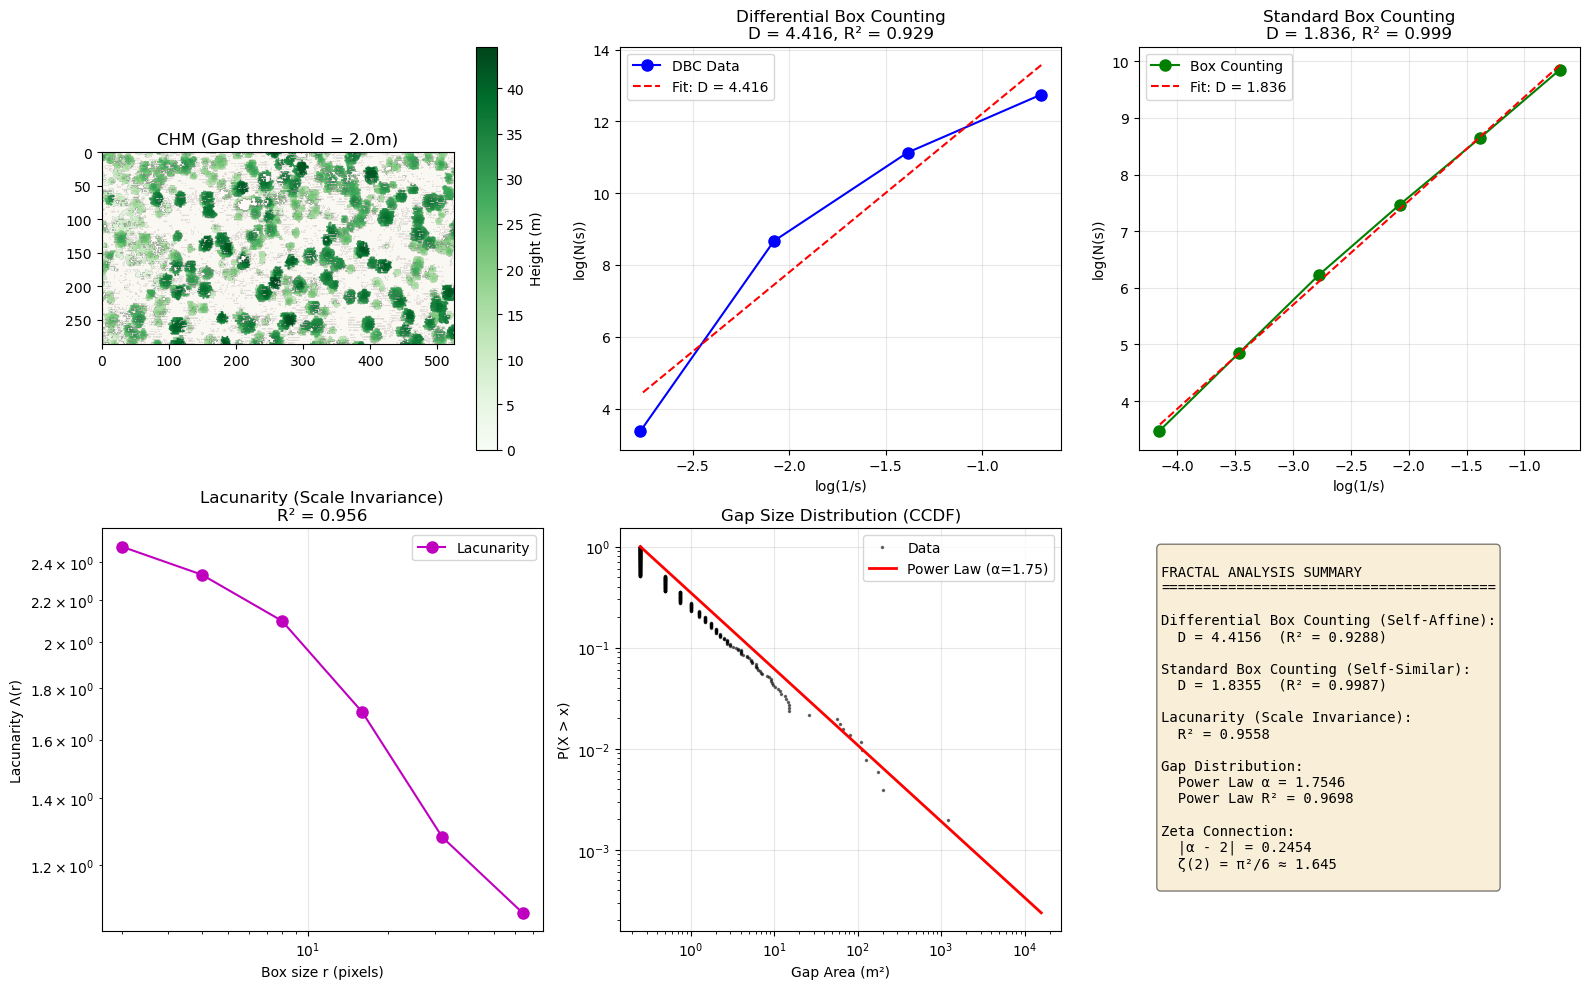

In [107]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. CHM with gaps highlighted
ax1 = axes[0, 0]
chm_display = np.ma.masked_where(~valid_mask, chm_array)
im1 = ax1.imshow(chm_display, cmap='Greens', vmin=0)
ax1.set_title(f'CHM (Gap threshold = {GAP_THRESHOLD}m)')
plt.colorbar(im1, ax=ax1, label='Height (m)')

# Overlay gaps
gap_overlay = np.ma.masked_where(chm_array >= GAP_THRESHOLD, np.ones_like(chm_array))
ax1.imshow(gap_overlay, cmap='Reds', alpha=0.5)

# 2. DBC log-log plot
ax2 = axes[0, 1]
if len(scales_dbc) > 0:
    ax2.plot(np.log(1/scales_dbc), np.log(Ns_dbc), 'bo-', markersize=8, label='DBC Data')
    coeffs = np.polyfit(np.log(1/scales_dbc), np.log(Ns_dbc), 1)
    x_fit = np.log(1/scales_dbc)
    ax2.plot(x_fit, np.polyval(coeffs, x_fit), 'r--', 
             label=f'Fit: D = {D_dbc:.3f}')
ax2.set_xlabel('log(1/s)')
ax2.set_ylabel('log(N(s))')
ax2.set_title(f'Differential Box Counting\nD = {D_dbc:.3f}, R² = {r2_dbc:.3f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Standard box counting comparison
ax3 = axes[0, 2]
if len(scales_bc) > 0:
    ax3.plot(np.log(1/scales_bc), np.log(Ns_bc), 'go-', markersize=8, label='Box Counting')
    coeffs_bc = np.polyfit(np.log(1/scales_bc), np.log(Ns_bc), 1)
    x_fit_bc = np.log(1/scales_bc)
    ax3.plot(x_fit_bc, np.polyval(coeffs_bc, x_fit_bc), 'r--',
             label=f'Fit: D = {D_bc:.3f}')
ax3.set_xlabel('log(1/s)')
ax3.set_ylabel('log(N(s))')
ax3.set_title(f'Standard Box Counting\nD = {D_bc:.3f}, R² = {r2_bc:.3f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Lacunarity curve
ax4 = axes[1, 0]
if len(lac_sizes) > 0:
    ax4.loglog(lac_sizes, lacunarity, 'mo-', markersize=8, label='Lacunarity')
    ax4.set_xlabel('Box size r (pixels)')
    ax4.set_ylabel('Lacunarity Λ(r)')
    ax4.set_title(f'Lacunarity (Scale Invariance)\nR² = {r2_lac:.3f}')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Gap size distribution
ax5 = axes[1, 1]
if 'sorted_areas' in gap_results:
    ax5.loglog(gap_results['sorted_areas'], gap_results['ccdf'], 'k.', 
               alpha=0.5, markersize=3, label='Data')
    
    # Plot power law fit
    x_range = np.logspace(np.log10(gap_results['min_area']), 
                          np.log10(gap_results['max_area']), 100)
    alpha = gap_results['power_law']['alpha']
    y_pl = (x_range / gap_results['min_area']) ** (-(alpha - 1))
    ax5.loglog(x_range, y_pl, 'r-', linewidth=2, 
               label=f'Power Law (α={alpha:.2f})')
    
ax5.set_xlabel('Gap Area (m²)')
ax5.set_ylabel('P(X > x)')
ax5.set_title('Gap Size Distribution (CCDF)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Summary statistics
ax6 = axes[1, 2]
ax6.axis('off')

summary_text = f"""
FRACTAL ANALYSIS SUMMARY
{'='*40}

Differential Box Counting (Self-Affine):
  D = {D_dbc:.4f}  (R² = {r2_dbc:.4f})
  
Standard Box Counting (Self-Similar):
  D = {D_bc:.4f}  (R² = {r2_bc:.4f})
  
Lacunarity (Scale Invariance):
  R² = {r2_lac:.4f}
  
Gap Distribution:
  Power Law α = {gap_results.get('power_law', {}).get('alpha', np.nan):.4f}
  Power Law R² = {gap_results.get('power_law', {}).get('r2', 0):.4f}
  
Zeta Connection:
  |α - 2| = {gap_results.get('zeta_connection', {}).get('alpha_vs_zeta2', np.nan):.4f}
  ζ(2) = π²/6 ≈ 1.645
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save figure
fig_path = OUTPUT_DIR / 'fractal_analysis_results.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Figure saved to: {fig_path}")

plt.show()

## 10. Export Results

In [108]:
# Compile all results
results = {
    'metadata': {
        'chm_path': str(CHM_PATH),
        'analysis_date': datetime.now().isoformat(),
        'gap_threshold_m': GAP_THRESHOLD,
        'nodata_value': float(NODATA_VALUE),
        'aoi_selected': selected_aoi['bounds_native'] is not None
    },
    'differential_box_counting': {
        'fractal_dimension': float(D_dbc),
        'r_squared': float(r2_dbc),
        'scales': scales_dbc.tolist() if len(scales_dbc) > 0 else [],
        'counts': Ns_dbc.tolist() if len(Ns_dbc) > 0 else [],
        'interpretation': 'self-affine surface dimension'
    },
    'standard_box_counting': {
        'fractal_dimension': float(D_bc),
        'r_squared': float(r2_bc),
        'scales': scales_bc.tolist() if len(scales_bc) > 0 else [],
        'counts': Ns_bc.tolist() if len(Ns_bc) > 0 else [],
        'interpretation': 'self-similar boundary dimension'
    },
    'lacunarity': {
        'r_squared': float(r2_lac),
        'box_sizes': lac_sizes.tolist() if len(lac_sizes) > 0 else [],
        'values': lacunarity.tolist() if len(lacunarity) > 0 else [],
        'interpretation': 'scale invariance measure'
    },
    'gap_distribution': {
        'n_gaps': gap_results.get('n_gaps', 0),
        'power_law_alpha': float(gap_results.get('power_law', {}).get('alpha', np.nan)),
        'power_law_r2': float(gap_results.get('power_law', {}).get('r2', 0)),
        'exponential_r2': float(gap_results.get('exponential', {}).get('r2', 0)),
        'zeta_2': float(np.pi**2 / 6),
        'alpha_vs_zeta2': float(gap_results.get('zeta_connection', {}).get('alpha_vs_zeta2', np.nan))
    },
    'hypothesis_tests': {
        'H1_optimal_filling': {
            'D_dbc': float(D_dbc),
            'prediction': 'old_growth' if D_dbc >= 2.6 else ('disturbed' if D_dbc >= 2.3 else 'plantation')
        },
        'H2_scale_invariance': {
            'lacunarity_r2': float(r2_lac),
            'prediction': 'old_growth' if r2_lac > 0.95 else ('disturbed' if r2_lac > 0.7 else 'plantation')
        },
        'H3_zeta_distribution': {
            'power_law_alpha': float(gap_results.get('power_law', {}).get('alpha', np.nan)),
            'power_law_better': gap_results.get('power_law', {}).get('r2', 0) > gap_results.get('exponential', {}).get('r2', 0),
            'prediction': 'old_growth' if (gap_results.get('power_law', {}).get('r2', 0) > 0.8 and 
                                           1.8 <= gap_results.get('power_law', {}).get('alpha', 0) <= 2.2) else 'disturbed_or_plantation'
        }
    }
}

# Save to JSON
results_path = OUTPUT_DIR / 'fractal_analysis_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"Results saved to: {results_path}")
print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

Results saved to: /home/jovyan/3dep/outputs/fractal_analysis/fractal_analysis_results.json

ANALYSIS COMPLETE


---

## References

### Methods
- Sarkar, N., & Chaudhuri, B.B. (1994). An efficient differential box-counting approach to compute fractal dimension of image. *IEEE Transactions on Systems, Man, and Cybernetics*.
- Allain, C., & Cloitre, M. (1991). Characterizing the lacunarity of random and deterministic fractal sets. *Physical Review A*.

### Ecological Applications
- West, G.B., Brown, J.H., & Enquist, B.J. (1997). A general model for the origin of allometric scaling laws in biology. *Science*.
- Mandelbrot, B.B. (1983). *The Fractal Geometry of Nature*. W.H. Freeman.

### Zeta Function in Physics
- Montgomery, H.L. (1973). The pair correlation of zeros of the zeta function. *Analytic Number Theory*.
- Lapidus, M.L., & van Frankenhuijsen, M. (2006). *Fractal Geometry, Complex Dimensions and Zeta Functions*. Springer.